## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
#import pickle5 as pickle
import pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
#from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
#from sklearn_hierarchical_classification.constants import ROOT
#from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled


## Import data and holdout data for prediction

In [2]:
'''CSV'''

df = pd.read_csv(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/technical_team.csv')

 
#Holding out 5 rows from the original dataframe for prediction at the end
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [3]:
'''lowercase data'''
import clean_dataset as clean

df['all_text_clean_spacy'] = df['all_text_clean_spacy'].apply(clean.basic)

#to_multi_class:
import tools as tools
df, df_lambda = tools.count_labels (df)


[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Shape:(7, 2)


,category,Count
0,chemicals_and_waste_programme,39
1,climate_change_adaptation_programme,97
2,climate_change_mitigation_programme,3
3,climate_strategies_and_policy_programme,116
4,ecosystems_and_biodiversity_programme,186
5,energy_program_of_climate_change_mitigation,110
6,oceans_and_water_programme,42


In [4]:
df

,PIMS_ID,all_text_clean,all_text_clean_spacy,technical_team,chemicals_and_waste_programme,climate_change_adaptation_programme,climate_change_mitigation_programme,climate_strategies_and_policy_programme,ecosystems_and_biodiversity_programme,energy_program_of_climate_change_mitigation,oceans_and_water_programme,category,cat
5,2284,the egyptian government is a strong proponent ...,egyptian government strong proponent renewable...,['energy_program_of_climate_change_mitigation'],0,0,0,0,0,1,0,energy_program_of_climate_change_mitigation,5
6,2564,the primary goal of the national capacity self...,primary goal national capacity self assessment...,['climate_strategies_and_policy_programme'],0,0,0,1,0,0,0,climate_strategies_and_policy_programme,3
7,2596,the overall objective of the project is to red...,overall objective project reduce environmental...,['chemicals_and_waste_programme'],1,0,0,0,0,0,0,chemicals_and_waste_programme,0
8,2762,madagascar is recognized as one of the greates...,madagascar recognize great mega diversity hots...,['ecosystems_and_biodiversity_programme'],0,0,0,0,1,0,0,ecosystems_and_biodiversity_programme,4
9,2890,the binational artibonite river basin has suff...,binational artibonite river basin suffer accel...,['ecosystems_and_biodiversity_programme'],0,0,0,0,1,0,0,ecosystems_and_biodiversity_programme,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,6520,the project will provide technical assistance ...,project provide technical assistance target co...,['climate_change_adaptation_programme'],0,1,0,0,0,0,0,climate_change_adaptation_programme,1
594,6532,the objective of the partnership initiative is...,objective partnership initiative enhance benef...,['climate_strategies_and_policy_programme'],0,0,0,1,0,0,0,climate_strategies_and_policy_programme,3
595,6533,in order to make progress on the articulation ...,order progress articulation programme african ...,['climate_change_adaptation_programme'],0,1,0,0,0,0,0,climate_change_adaptation_programme,1
596,6539,capacities of daes and state governments enhan...,capacity daes state governments enhance plan i...,['climate_strategies_and_policy_programme'],0,0,0,1,0,0,0,climate_strategies_and_policy_programme,3


In [5]:
#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 0.1, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)
#X = X.toarray()

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
y = df['cat'].values

##  Features engineering

## Train multiple ML models

In [6]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Logistic Regression': LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', class_weight = "balanced"),
              'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log', class_weight = "balanced"),
              'Random Forest': RandomForestClassifier(random_state=3, class_weight = "balanced"),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['cat'].values,
                                                    test_size = .3,
                                                    stratify=df['cat'].values,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()
#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)


train size: 415
test size: 178


C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defin

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Logistic Regression,0.955056,0.961407,0.95,0.954018
2,Stochastic Gradient Descent,0.949438,0.814909,0.806895,0.809076
7,K Nearest Neighbor,0.91573,0.786573,0.79679,0.788495
3,Random Forest,0.904494,0.801006,0.727304,0.745104
4,Decsision Tree,0.730337,0.666361,0.747629,0.692401
6,Gaussian Naive Bayes,0.820225,0.785185,0.64611,0.664998
5,AdaBoost,0.601124,0.470686,0.453344,0.444194
1,Dummy,0.207865,0.154172,0.153826,0.151345


## Hyperparameter tuning

In [15]:
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.6min finished


In [64]:
print (gridsearch.best_params_)

{'alpha': 1e-06, 'loss': 'log', 'max_iter': 5, 'penalty': 'l1', 'random_state': 3, 'tol': None}


In [57]:
#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

/home/oumaima/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 19.2min finished


In [62]:
print (gridsearch.best_params_)

{'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 800, 'random_state': 3}


In [65]:
#Define the best models with the selected params from the grdsearch

sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=5,
                               penalty='l1',
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 10,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 800,
                                       random_state=3)

## Plot AUC - SGD

/home/oumaima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


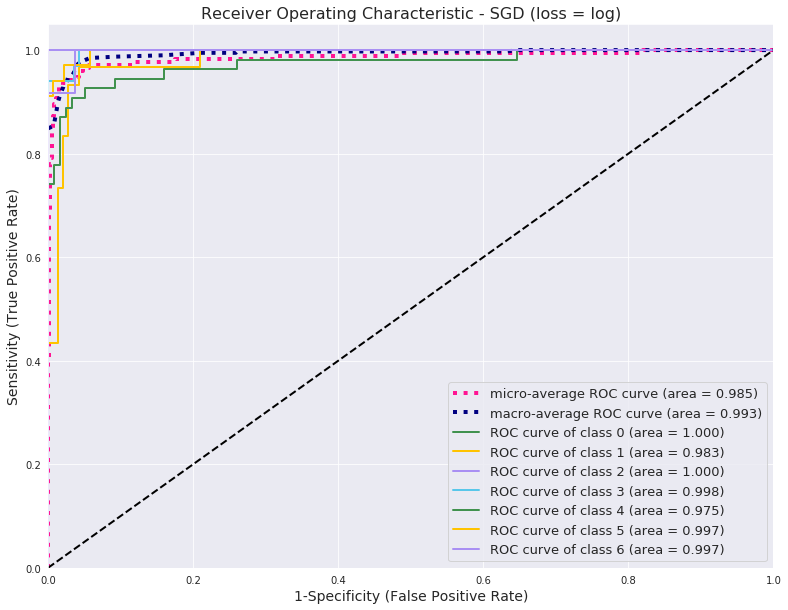

In [66]:
#Binarize the labels
from sklearn.preprocessing import label_binarize
'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
y_b = label_binarize(y, classes = [0, 1, 2, 3, 4, 5, 6])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix - SGD

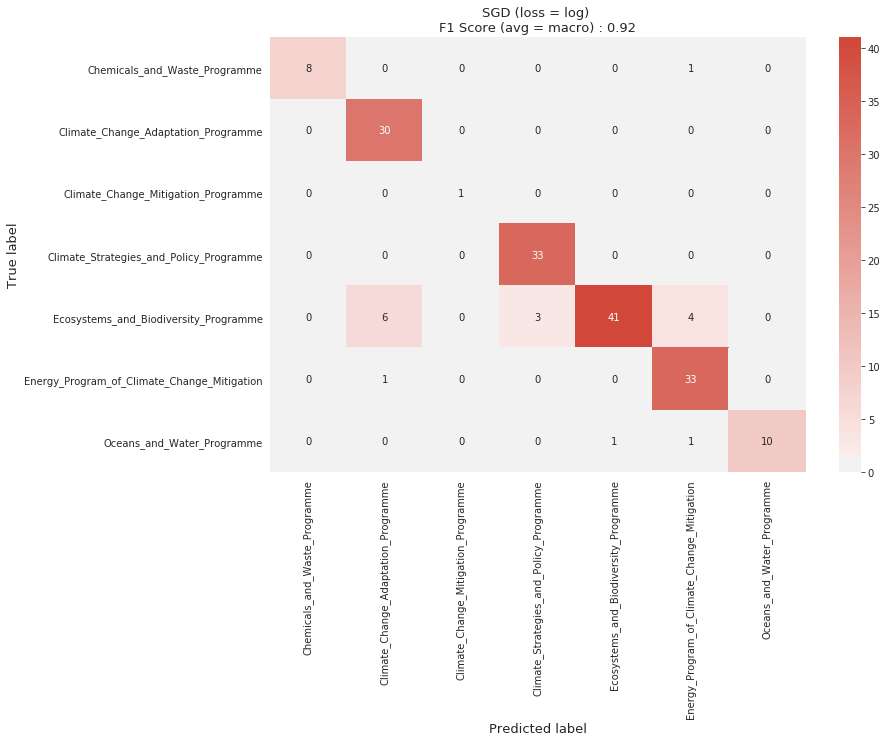

In [67]:
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'], 
                     columns = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Plot AUC - RF

/home/oumaima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


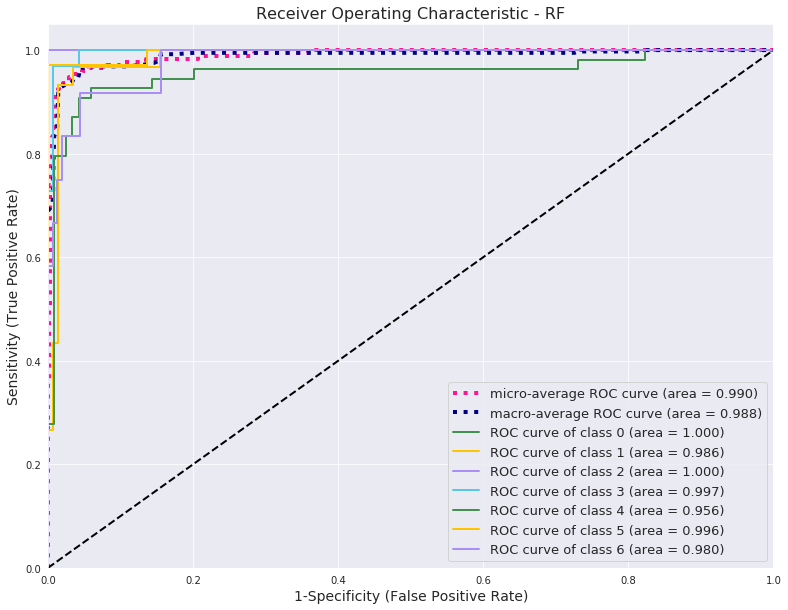

In [68]:
#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix - RF

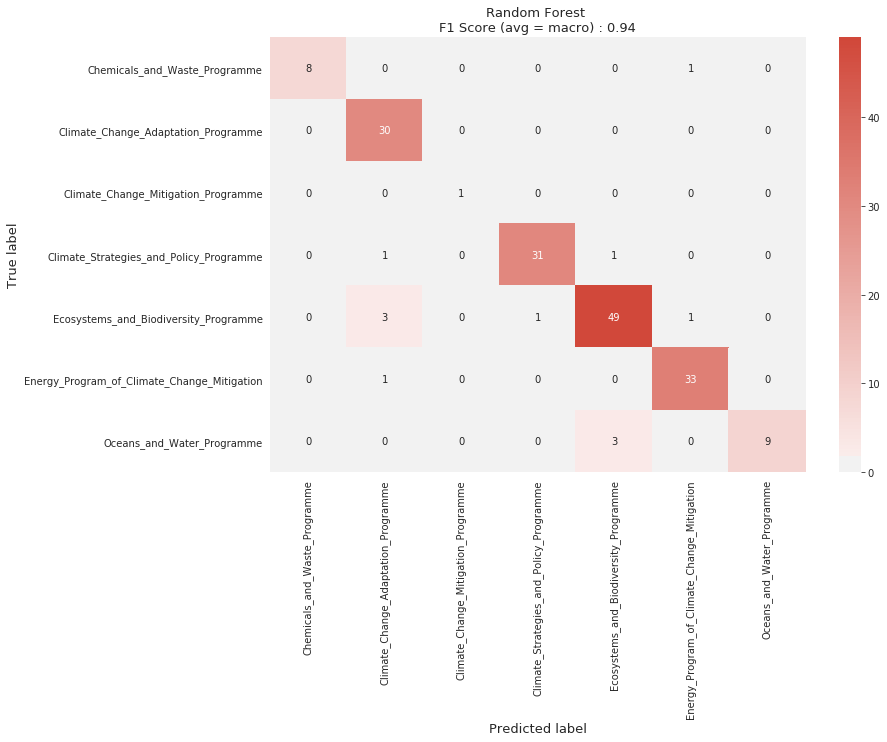

In [69]:
#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'], 
                     columns = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Putting it all together to make predictions on the unseen text

In [97]:
#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['all_text_clean'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Chemicals_and_Waste_Programme': 0,
                  'Climate_Change_Adaptation_Programme': 1,
                  'Climate_Change_Mitigation_Programme': 2,
                  'Climate_Strategies_and_Policy_Programme': 3,
                 'Ecosystems_and_Biodiversity_Programme': 4,
                 'Energy_Program_of_Climate_Change_Mitigation': 5,
                 'Oceans_and_Water_Programme': 6}
l = []
for i in df_holdout['technical_team']:
    for s in i:
        l.append(s)
df_holdout['technical_team']  = l 
df_holdout['correct'] = df_holdout['technical_team'].map(label_num_dict)
df_holdout = pd.DataFrame(df_holdout, columns = ['all_text_clean', 'technical_team', 'pred_sgd', 'pred_rf', 'correct'])

df_holdout

,all_text_clean,technical_team,pred_sgd,pred_rf,correct
0,this programme will contribute to the protecti...,Ecosystems_and_Biodiversity_Programme,4,4,4
1,the project contributes to the number of gef p...,Ecosystems_and_Biodiversity_Programme,0,5,4
2,the cape floristic region cfr biodiversity hot...,Ecosystems_and_Biodiversity_Programme,4,4,4
3,the niger delta region of nigeria covering an ...,Ecosystems_and_Biodiversity_Programme,4,4,4
4,the government of south africa has developed t...,Ecosystems_and_Biodiversity_Programme,4,4,4
